In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
import argparse
import copy
from tqdm import tqdm
from statistics import mean, stdev
from sklearn import metrics

import torch
from diffusers import DPMSolverMultistepScheduler
from tree_ring.inverse_stable_diffusion import InversableStableDiffusionPipeline
import open_clip
from tree_ring.optim_utils import *
from tree_ring.io_utils import *
import re
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def extract_id(string):
    match = re.search(r'sent(\d+)_frames', string)
    if match:
        return match.group(1)
    else:
        return None


/root/miniconda3/envs/integrate/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
parser = argparse.ArgumentParser(description='diffusion watermark')
parser.add_argument('--model_id', default='/root/.cache/huggingface/diffusers/models--stabilityai--stable-diffusion-2-1-base/snapshots/5ede9e4bf3e3fd1cb0ef2f7a3fff13ee514fdf06/')
parser.add_argument('--test_num_inference_steps', default=None, type=int)
parser.add_argument('--num_inference_steps', default=50, type=int)

# watermark
parser.add_argument('--w_mask_shape', default='circle')

parser.add_argument('--w_measurement', default='l1_complex')
parser.add_argument('--w_radius', default=10)
parser.add_argument('--w_channel', default=0, type=int)

parser.add_argument('--orig_img_no_w_path',default='../datas/videos/text2video-zero/static_radius:10/8frames_uniform' ,type=str)
parser.add_argument('--orig_img_w_path',default='../datas/videos/text2video-zero/static_radius:10/8frames_uniform_w', type=str)

# for image distortion



parser.add_argument('--r_degree', default=None, type=float)
parser.add_argument('--jpeg_ratio', default=None, type=int)
parser.add_argument('--crop_scale', default=0.75, type=float)
parser.add_argument('--crop_ratio', default=0.75, type=float)
parser.add_argument('--gaussian_blur_r', default=None, type=int)
parser.add_argument('--gaussian_std', default=None, type=float)
parser.add_argument('--brightness_factor', default=None, type=float)
parser.add_argument('--rand_aug', default=0, type=int)
args = parser.parse_args([])

if args.test_num_inference_steps is None:
    args.test_num_inference_steps = args.num_inference_steps

In [4]:
scheduler = DPMSolverMultistepScheduler.from_pretrained(args.model_id, subfolder='scheduler')
pipe = InversableStableDiffusionPipeline.from_pretrained(
    args.model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision='fp16',
    )
pipe = pipe.to(device)

/root/miniconda3/envs/integrate/lib/python3.9/site-packages/transformers/modeling_utils.py:402: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:


In [5]:
def get_watermarking_mask(init_latents_w, w_radius, device, w_channel=3):
    watermarking_mask = torch.zeros(init_latents_w.shape, dtype=torch.bool).to(
        device
    )
    np_mask = circle_mask(init_latents_w.shape[-1], r=w_radius)
    torch_mask = torch.tensor(np_mask).to(device)

    if w_channel == -1:
        # all channels
        watermarking_mask[:, :] = torch_mask
    else:
        watermarking_mask[:, w_channel] = torch_mask
    return watermarking_mask

In [6]:
tester_prompt = '' # assume at the detection time, the original prompt is unknown
text_embeddings = pipe.get_text_embedding(tester_prompt)

# ground-truth patch
gt_patch = torch.load('./tree_ring/key.pt').to(dtype=torch.complex32)
init_latents_w = pipe.get_random_latents()
watermarking_mask = get_watermarking_mask(init_latents_w, 10, device)
no_w_metrics=[]
w_metrics=[]

/tmp/ipykernel_1487986/4069353625.py:5: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:31.)
  gt_patch = torch.load('./tree_ring/key.pt').to(dtype=torch.complex32)


In [7]:
for idx_video in range(100):
    print(f'---------------------idx_video:{idx_video}----------------------------')
    for idx_frame in range(8):
        frame_path_no_w = f'{args.orig_img_no_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'
        frame_path_w = f'{args.orig_img_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'

        img_no_w = Image.open(frame_path_no_w)
        img_w = Image.open(frame_path_w)
        img_no_w = transform_img(img_no_w).unsqueeze(0).to(text_embeddings.dtype).to(device)
        img_w = transform_img(img_w).unsqueeze(0).to(text_embeddings.dtype).to(device)

        image_latents_no_w = pipe.get_image_latents(img_no_w, sample=False)
        image_latents_w = pipe.get_image_latents(img_w, sample=False)

        reversed_latents_no_w = pipe.forward_diffusion(
        latents=image_latents_no_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )

        reversed_latents_w = pipe.forward_diffusion(
        latents=image_latents_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )
        no_w_metric, w_metric = eval_watermark(reversed_latents_no_w, reversed_latents_w, watermarking_mask, gt_patch, args)
        no_w_metrics.append(-no_w_metric)
        w_metrics.append(-w_metric)

---------------------idx_video:0----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.96it/s]


---------------------idx_video:1----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.07it/s]


---------------------idx_video:2----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.29it/s]


---------------------idx_video:3----------------------------


100%|██████████| 50/50 [00:00<00:00, 51.76it/s]


---------------------idx_video:4----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.35it/s]


---------------------idx_video:5----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.52it/s]


---------------------idx_video:6----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.83it/s]


---------------------idx_video:7----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.11it/s]


---------------------idx_video:8----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.70it/s]


---------------------idx_video:9----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


---------------------idx_video:10----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.06it/s]


---------------------idx_video:11----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.01it/s]


---------------------idx_video:12----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.00it/s]


---------------------idx_video:13----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.25it/s]


---------------------idx_video:14----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


---------------------idx_video:15----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.90it/s]


---------------------idx_video:16----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.77it/s]


---------------------idx_video:17----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.74it/s]


---------------------idx_video:18----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.89it/s]


---------------------idx_video:19----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.91it/s]


---------------------idx_video:20----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.20it/s]


---------------------idx_video:21----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.43it/s]


---------------------idx_video:22----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.77it/s]


---------------------idx_video:23----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.82it/s]


---------------------idx_video:24----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.54it/s]


---------------------idx_video:25----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.77it/s]


---------------------idx_video:26----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.17it/s]


---------------------idx_video:27----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.85it/s]


---------------------idx_video:28----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.12it/s]


---------------------idx_video:29----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.96it/s]


---------------------idx_video:30----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.89it/s]


---------------------idx_video:31----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.03it/s]


---------------------idx_video:32----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.75it/s]


---------------------idx_video:33----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.28it/s]


---------------------idx_video:34----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.22it/s]


---------------------idx_video:35----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.91it/s]


---------------------idx_video:36----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.22it/s]


---------------------idx_video:37----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.75it/s]


---------------------idx_video:38----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.50it/s]


---------------------idx_video:39----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.58it/s]


---------------------idx_video:40----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.64it/s]


---------------------idx_video:41----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.12it/s]


---------------------idx_video:42----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.93it/s]


---------------------idx_video:43----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.81it/s]


---------------------idx_video:44----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.80it/s]


---------------------idx_video:45----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.01it/s]


---------------------idx_video:46----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.91it/s]


---------------------idx_video:47----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.84it/s]


---------------------idx_video:48----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.89it/s]


---------------------idx_video:49----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.76it/s]


---------------------idx_video:50----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.05it/s]


---------------------idx_video:51----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.31it/s]


---------------------idx_video:52----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.25it/s]


---------------------idx_video:53----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.89it/s]


---------------------idx_video:54----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.20it/s]


---------------------idx_video:55----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.85it/s]


---------------------idx_video:56----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.64it/s]


---------------------idx_video:57----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.15it/s]


---------------------idx_video:58----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.08it/s]


---------------------idx_video:59----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.27it/s]


---------------------idx_video:60----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.83it/s]


---------------------idx_video:61----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.36it/s]


---------------------idx_video:62----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.75it/s]


---------------------idx_video:63----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.38it/s]


---------------------idx_video:64----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.13it/s]


---------------------idx_video:65----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.68it/s]


---------------------idx_video:66----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.13it/s]


---------------------idx_video:67----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.90it/s]


---------------------idx_video:68----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.98it/s]


---------------------idx_video:69----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.93it/s]


---------------------idx_video:70----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.58it/s]


---------------------idx_video:71----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.13it/s]


---------------------idx_video:72----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.83it/s]


---------------------idx_video:73----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.81it/s]


---------------------idx_video:74----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.64it/s]


---------------------idx_video:75----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.50it/s]


---------------------idx_video:76----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.23it/s]


---------------------idx_video:77----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.77it/s]


---------------------idx_video:78----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.85it/s]


---------------------idx_video:79----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.71it/s]


---------------------idx_video:80----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.97it/s]


---------------------idx_video:81----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.98it/s]


---------------------idx_video:82----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.16it/s]


---------------------idx_video:83----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.50it/s]


---------------------idx_video:84----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.97it/s]


---------------------idx_video:85----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.29it/s]


---------------------idx_video:86----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.70it/s]


---------------------idx_video:87----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.10it/s]


---------------------idx_video:88----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.91it/s]


---------------------idx_video:89----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.11it/s]


---------------------idx_video:90----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.31it/s]


---------------------idx_video:91----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.13it/s]


---------------------idx_video:92----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.07it/s]


---------------------idx_video:93----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.31it/s]


---------------------idx_video:94----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.43it/s]


---------------------idx_video:95----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.88it/s]


---------------------idx_video:96----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.53it/s]


---------------------idx_video:97----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.75it/s]


---------------------idx_video:98----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.71it/s]


---------------------idx_video:99----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.16it/s]


In [8]:
preds = no_w_metrics +  w_metrics
t_labels = [0] * len(no_w_metrics) + [1] * len(w_metrics)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)

0.92375


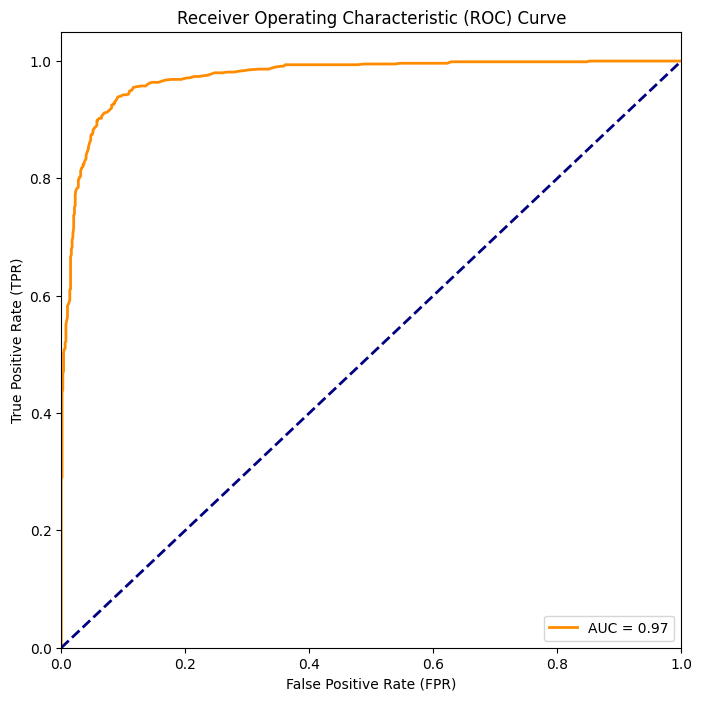

In [9]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [10]:
# 分割原始列表，每8个元素为一组
split_lists_no = [no_w_metrics[i:i+8] for i in range(0, len(no_w_metrics), 8)]

# 计算每组的平均值
average_values_no = [sum(sub_list) / len(sub_list) for sub_list in split_lists_no]

# 分割原始列表，每8个元素为一组
split_lists_w = [w_metrics[i:i+8] for i in range(0, len(w_metrics), 8)]

# 计算每组的平均值
average_values_w = [sum(sub_list) / len(sub_list) for sub_list in split_lists_w]

In [11]:
preds = average_values_no +  average_values_w
t_labels = [0] * len(average_values_no) + [1] * len(average_values_w)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)

0.97


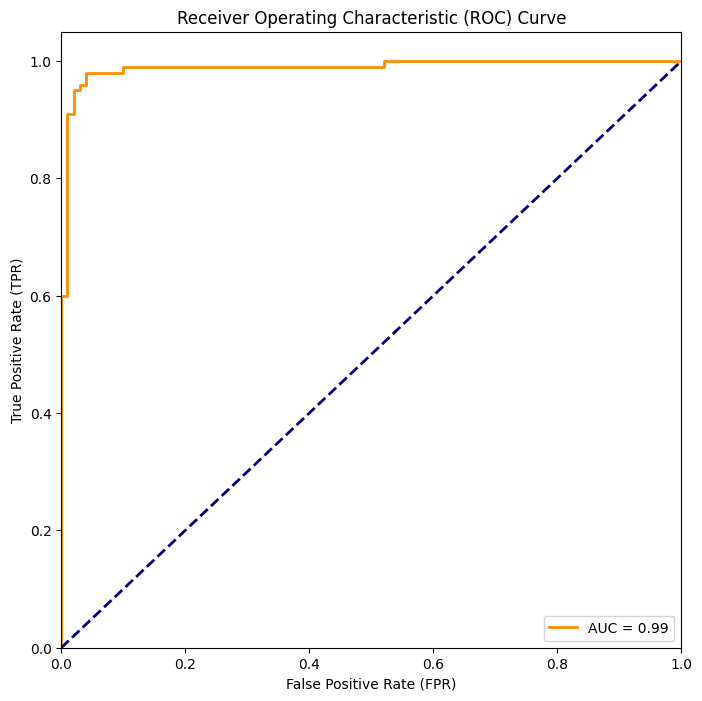

In [12]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [14]:
no_w_metrics=[]
w_metrics=[]
args.crop_scale=None
args.crop_ratio=None
args.r_degree=75
for idx_video in range(100):
    print(f'---------------------idx_video:{idx_video}----------------------------')
    for idx_frame in range(8):
        frame_path_no_w = f'{args.orig_img_no_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'
        frame_path_w = f'{args.orig_img_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'

        img_no_w = Image.open(frame_path_no_w)
        img_w = Image.open(frame_path_w)

        img_no_w, img_w = image_distortion(img_no_w, img_w, 42, args)

        img_no_w = transform_img(img_no_w).unsqueeze(0).to(text_embeddings.dtype).to(device)
        img_w = transform_img(img_w).unsqueeze(0).to(text_embeddings.dtype).to(device)

        image_latents_no_w = pipe.get_image_latents(img_no_w, sample=False)
        image_latents_w = pipe.get_image_latents(img_w, sample=False)

        reversed_latents_no_w = pipe.forward_diffusion(
        latents=image_latents_no_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )

        reversed_latents_w = pipe.forward_diffusion(
        latents=image_latents_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )

        no_w_metric, w_metric = eval_watermark(reversed_latents_no_w, reversed_latents_w, watermarking_mask, gt_patch, args)
        no_w_metrics.append(-no_w_metric)
        w_metrics.append(-w_metric)

---------------------idx_video:0----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.03it/s]


---------------------idx_video:1----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.99it/s]


---------------------idx_video:2----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.90it/s]


---------------------idx_video:3----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.68it/s]


---------------------idx_video:4----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.33it/s]


---------------------idx_video:5----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.08it/s]


---------------------idx_video:6----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.34it/s]


---------------------idx_video:7----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.19it/s]


---------------------idx_video:8----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.33it/s]


---------------------idx_video:9----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.21it/s]


---------------------idx_video:10----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.11it/s]


---------------------idx_video:11----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.18it/s]


---------------------idx_video:12----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.82it/s]


---------------------idx_video:13----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.97it/s]


---------------------idx_video:14----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.48it/s]


---------------------idx_video:15----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.19it/s]


---------------------idx_video:16----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.14it/s]


---------------------idx_video:17----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.63it/s]


---------------------idx_video:18----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.86it/s]


---------------------idx_video:19----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.84it/s]


---------------------idx_video:20----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.12it/s]


---------------------idx_video:21----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.07it/s]


---------------------idx_video:22----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.50it/s]


---------------------idx_video:23----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.85it/s]


---------------------idx_video:24----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.73it/s]


---------------------idx_video:25----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.12it/s]


---------------------idx_video:26----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.45it/s]


---------------------idx_video:27----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.59it/s]


---------------------idx_video:28----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.75it/s]


---------------------idx_video:29----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.87it/s]


---------------------idx_video:30----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.84it/s]


---------------------idx_video:31----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.12it/s]


---------------------idx_video:32----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.56it/s]


---------------------idx_video:33----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.09it/s]


---------------------idx_video:34----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.86it/s]


---------------------idx_video:35----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.57it/s]


---------------------idx_video:36----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.62it/s]


---------------------idx_video:37----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.09it/s]


---------------------idx_video:38----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.85it/s]


---------------------idx_video:39----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.23it/s]


---------------------idx_video:40----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.13it/s]


---------------------idx_video:41----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.06it/s]


---------------------idx_video:42----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.15it/s]


---------------------idx_video:43----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.09it/s]


---------------------idx_video:44----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.87it/s]


---------------------idx_video:45----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.79it/s]


---------------------idx_video:46----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.87it/s]


---------------------idx_video:47----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.35it/s]


---------------------idx_video:48----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.61it/s]


---------------------idx_video:49----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.96it/s]


---------------------idx_video:50----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.26it/s]


---------------------idx_video:51----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.92it/s]


---------------------idx_video:52----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.29it/s]


---------------------idx_video:53----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.23it/s]


---------------------idx_video:54----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.32it/s]


---------------------idx_video:55----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.13it/s]


---------------------idx_video:56----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.31it/s]


---------------------idx_video:57----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.28it/s]


---------------------idx_video:58----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.55it/s]


---------------------idx_video:59----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.03it/s]


---------------------idx_video:60----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.69it/s]


---------------------idx_video:61----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.97it/s]


---------------------idx_video:62----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.25it/s]


---------------------idx_video:63----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.82it/s]


---------------------idx_video:64----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.85it/s]


---------------------idx_video:65----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.62it/s]


---------------------idx_video:66----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.85it/s]


---------------------idx_video:67----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.71it/s]


---------------------idx_video:68----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.20it/s]


---------------------idx_video:69----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.79it/s]


---------------------idx_video:70----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.31it/s]


---------------------idx_video:71----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.31it/s]


---------------------idx_video:72----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.80it/s]


---------------------idx_video:73----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.01it/s]


---------------------idx_video:74----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.46it/s]


---------------------idx_video:75----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.25it/s]


---------------------idx_video:76----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.52it/s]


---------------------idx_video:77----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.96it/s]


---------------------idx_video:78----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.99it/s]


---------------------idx_video:79----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.92it/s]


---------------------idx_video:80----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.84it/s]


---------------------idx_video:81----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.85it/s]


---------------------idx_video:82----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.62it/s]


---------------------idx_video:83----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.22it/s]


---------------------idx_video:84----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.70it/s]


---------------------idx_video:85----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.16it/s]


---------------------idx_video:86----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.75it/s]


---------------------idx_video:87----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.60it/s]


---------------------idx_video:88----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.77it/s]


---------------------idx_video:89----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.16it/s]


---------------------idx_video:90----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.19it/s]


---------------------idx_video:91----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.97it/s]


---------------------idx_video:92----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.10it/s]


---------------------idx_video:93----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.03it/s]


---------------------idx_video:94----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.31it/s]


---------------------idx_video:95----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.90it/s]


---------------------idx_video:96----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.07it/s]


---------------------idx_video:97----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.26it/s]


---------------------idx_video:98----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.47it/s]


---------------------idx_video:99----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.67it/s]


0.8087500000000001


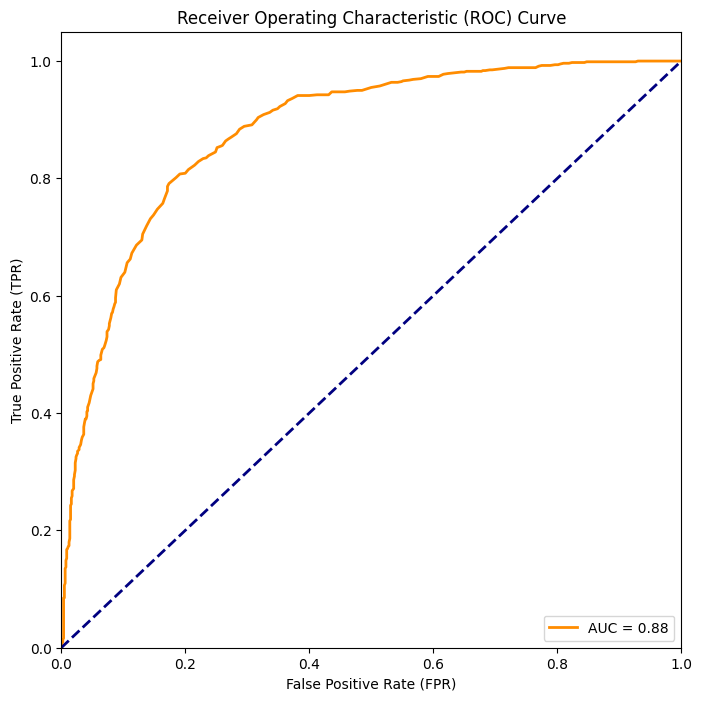

In [15]:
preds = no_w_metrics +  w_metrics
t_labels = [0] * len(no_w_metrics) + [1] * len(w_metrics)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

0.89


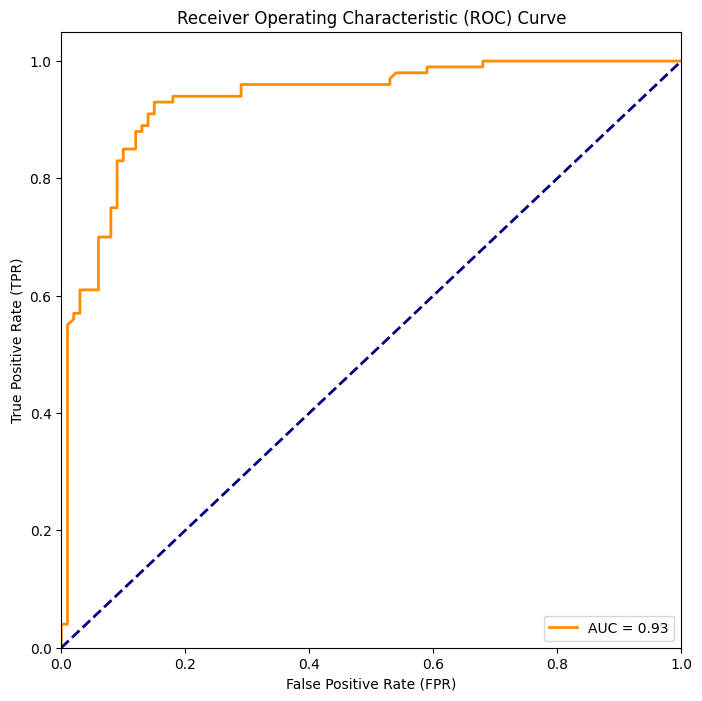

In [16]:
# 分割原始列表，每8个元素为一组
split_lists_no = [no_w_metrics[i:i+8] for i in range(0, len(no_w_metrics), 8)]

# 计算每组的平均值
average_values_no = [sum(sub_list) / len(sub_list) for sub_list in split_lists_no]

# 分割原始列表，每8个元素为一组
split_lists_w = [w_metrics[i:i+8] for i in range(0, len(w_metrics), 8)]

# 计算每组的平均值
average_values_w = [sum(sub_list) / len(sub_list) for sub_list in split_lists_w]

preds = average_values_no +  average_values_w
t_labels = [0] * len(average_values_no) + [1] * len(average_values_w)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)

import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [17]:
no_w_metrics=[]
w_metrics=[]
args.crop_scale=None
args.crop_ratio=None
args.r_degree=None
args.gaussian_blur_r=4
for idx_video in range(100):
    print(f'---------------------idx_video:{idx_video}----------------------------')
    for idx_frame in range(8):
        frame_path_no_w = f'{args.orig_img_no_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'
        frame_path_w = f'{args.orig_img_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'

        img_no_w = Image.open(frame_path_no_w)
        img_w = Image.open(frame_path_w)

        img_no_w, img_w = image_distortion(img_no_w, img_w, 42, args)

        img_no_w = transform_img(img_no_w).unsqueeze(0).to(text_embeddings.dtype).to(device)
        img_w = transform_img(img_w).unsqueeze(0).to(text_embeddings.dtype).to(device)

        image_latents_no_w = pipe.get_image_latents(img_no_w, sample=False)
        image_latents_w = pipe.get_image_latents(img_w, sample=False)

        reversed_latents_no_w = pipe.forward_diffusion(
        latents=image_latents_no_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )

        reversed_latents_w = pipe.forward_diffusion(
        latents=image_latents_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )

        no_w_metric, w_metric = eval_watermark(reversed_latents_no_w, reversed_latents_w, watermarking_mask, gt_patch, args)
        no_w_metrics.append(-no_w_metric)
        w_metrics.append(-w_metric)


---------------------idx_video:0----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.57it/s]


---------------------idx_video:1----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.44it/s]


---------------------idx_video:2----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.22it/s]


---------------------idx_video:3----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.27it/s]


---------------------idx_video:4----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.12it/s]


---------------------idx_video:5----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.96it/s]


---------------------idx_video:6----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.19it/s]


---------------------idx_video:7----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.20it/s]


---------------------idx_video:8----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.13it/s]


---------------------idx_video:9----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.67it/s]


---------------------idx_video:10----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.96it/s]


---------------------idx_video:11----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.48it/s]


---------------------idx_video:12----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.11it/s]


---------------------idx_video:13----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.85it/s]


---------------------idx_video:14----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.34it/s]


---------------------idx_video:15----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.12it/s]


---------------------idx_video:16----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.93it/s]


---------------------idx_video:17----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.86it/s]


---------------------idx_video:18----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.94it/s]


---------------------idx_video:19----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.72it/s]


---------------------idx_video:20----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.18it/s]


---------------------idx_video:21----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.86it/s]


---------------------idx_video:22----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.63it/s]


---------------------idx_video:23----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.45it/s]


---------------------idx_video:24----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.50it/s]


---------------------idx_video:25----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.09it/s]


---------------------idx_video:26----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.23it/s]


---------------------idx_video:27----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.04it/s]


---------------------idx_video:28----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.45it/s]


---------------------idx_video:29----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.04it/s]


---------------------idx_video:30----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.65it/s]


---------------------idx_video:31----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.74it/s]


---------------------idx_video:32----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.97it/s]


---------------------idx_video:33----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.67it/s]


---------------------idx_video:34----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.89it/s]


---------------------idx_video:35----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.25it/s]


---------------------idx_video:36----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.53it/s]


---------------------idx_video:37----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.83it/s]


---------------------idx_video:38----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.37it/s]


---------------------idx_video:39----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.20it/s]


---------------------idx_video:40----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.34it/s]


---------------------idx_video:41----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.25it/s]


---------------------idx_video:42----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.52it/s]


---------------------idx_video:43----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.61it/s]


---------------------idx_video:44----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.48it/s]


---------------------idx_video:45----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.04it/s]


---------------------idx_video:46----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.09it/s]


---------------------idx_video:47----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.38it/s]


---------------------idx_video:48----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.74it/s]


---------------------idx_video:49----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.79it/s]


---------------------idx_video:50----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.35it/s]


---------------------idx_video:51----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.28it/s]


---------------------idx_video:52----------------------------


100%|██████████| 50/50 [00:00<00:00, 59.80it/s]


---------------------idx_video:53----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.65it/s]


---------------------idx_video:54----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.90it/s]


---------------------idx_video:55----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.78it/s]


---------------------idx_video:56----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.97it/s]


---------------------idx_video:57----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.79it/s]


---------------------idx_video:58----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.62it/s]


---------------------idx_video:59----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.70it/s]


---------------------idx_video:60----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.24it/s]


---------------------idx_video:61----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.62it/s]


---------------------idx_video:62----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.63it/s]


---------------------idx_video:63----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.64it/s]


---------------------idx_video:64----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.05it/s]


---------------------idx_video:65----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.93it/s]


---------------------idx_video:66----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.81it/s]


---------------------idx_video:67----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.77it/s]


---------------------idx_video:68----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.88it/s]


---------------------idx_video:69----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.70it/s]


---------------------idx_video:70----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.66it/s]


---------------------idx_video:71----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.74it/s]


---------------------idx_video:72----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.82it/s]


---------------------idx_video:73----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.42it/s]


---------------------idx_video:74----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.83it/s]


---------------------idx_video:75----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.36it/s]


---------------------idx_video:76----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.82it/s]


---------------------idx_video:77----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.51it/s]


---------------------idx_video:78----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.93it/s]


---------------------idx_video:79----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.63it/s]


---------------------idx_video:80----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.97it/s]


---------------------idx_video:81----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.84it/s]


---------------------idx_video:82----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.74it/s]


---------------------idx_video:83----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.82it/s]


---------------------idx_video:84----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.75it/s]


---------------------idx_video:85----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.64it/s]


---------------------idx_video:86----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.54it/s]


---------------------idx_video:87----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.77it/s]


---------------------idx_video:88----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.72it/s]


---------------------idx_video:89----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.62it/s]


---------------------idx_video:90----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.60it/s]


---------------------idx_video:91----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.00it/s]


---------------------idx_video:92----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.17it/s]


---------------------idx_video:93----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.60it/s]


---------------------idx_video:94----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.94it/s]


---------------------idx_video:95----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.64it/s]


---------------------idx_video:96----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.99it/s]


---------------------idx_video:97----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.71it/s]


---------------------idx_video:98----------------------------


100%|██████████| 50/50 [00:00<00:00, 59.66it/s]


---------------------idx_video:99----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.30it/s]


0.768125


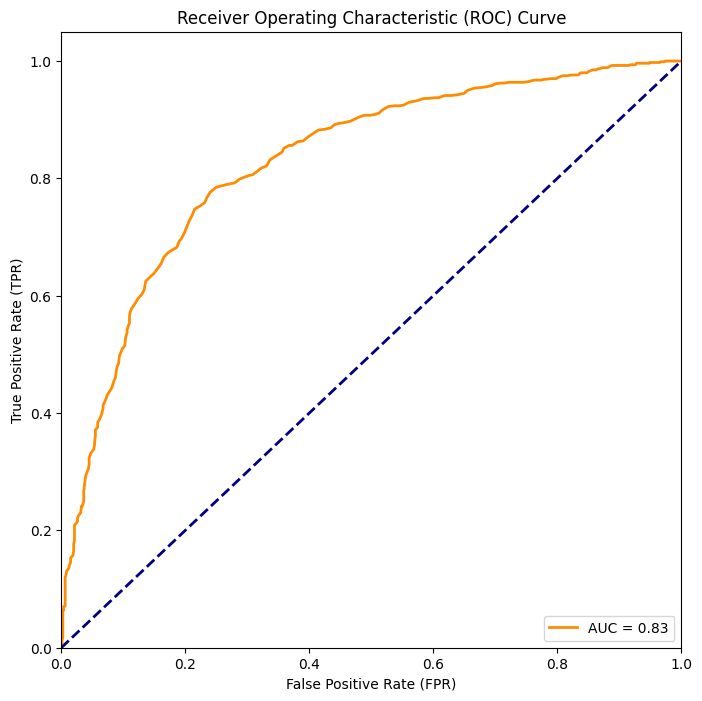

In [18]:
preds = no_w_metrics +  w_metrics
t_labels = [0] * len(no_w_metrics) + [1] * len(w_metrics)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

0.815


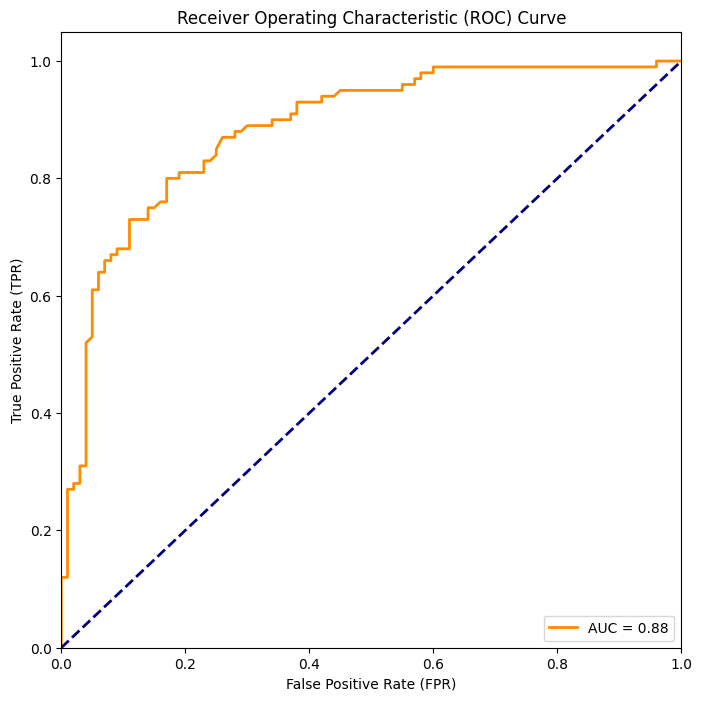

In [19]:
# 分割原始列表，每8个元素为一组
split_lists_no = [no_w_metrics[i:i+8] for i in range(0, len(no_w_metrics), 8)]

# 计算每组的平均值
average_values_no = [sum(sub_list) / len(sub_list) for sub_list in split_lists_no]

# 分割原始列表，每8个元素为一组
split_lists_w = [w_metrics[i:i+8] for i in range(0, len(w_metrics), 8)]

# 计算每组的平均值
average_values_w = [sum(sub_list) / len(sub_list) for sub_list in split_lists_w]

preds = average_values_no +  average_values_w
t_labels = [0] * len(average_values_no) + [1] * len(average_values_w)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)

import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [20]:
no_w_metrics=[]
w_metrics=[]
args.crop_scale=None
args.crop_ratio=None
args.r_degree=None
args.gaussian_blur_r=None
args.gaussian_std=0.1
for idx_video in range(100):
    print(f'---------------------idx_video:{idx_video}----------------------------')
    for idx_frame in range(8):
        frame_path_no_w = f'{args.orig_img_no_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'
        frame_path_w = f'{args.orig_img_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'

        img_no_w = Image.open(frame_path_no_w)
        img_w = Image.open(frame_path_w)

        img_no_w, img_w = image_distortion(img_no_w, img_w, 42, args)

        img_no_w = transform_img(img_no_w).unsqueeze(0).to(text_embeddings.dtype).to(device)
        img_w = transform_img(img_w).unsqueeze(0).to(text_embeddings.dtype).to(device)

        image_latents_no_w = pipe.get_image_latents(img_no_w, sample=False)
        image_latents_w = pipe.get_image_latents(img_w, sample=False)

        reversed_latents_no_w = pipe.forward_diffusion(
        latents=image_latents_no_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )

        reversed_latents_w = pipe.forward_diffusion(
        latents=image_latents_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )

        no_w_metric, w_metric = eval_watermark(reversed_latents_no_w, reversed_latents_w, watermarking_mask, gt_patch, args)
        no_w_metrics.append(-no_w_metric)
        w_metrics.append(-w_metric)


---------------------idx_video:0----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.88it/s]


---------------------idx_video:1----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.11it/s]


---------------------idx_video:2----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.03it/s]


---------------------idx_video:3----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.65it/s]


---------------------idx_video:4----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.77it/s]


---------------------idx_video:5----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.98it/s]


---------------------idx_video:6----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.44it/s]


---------------------idx_video:7----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.18it/s]


---------------------idx_video:8----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.54it/s]


---------------------idx_video:9----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.98it/s]


---------------------idx_video:10----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.14it/s]


---------------------idx_video:11----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.90it/s]


---------------------idx_video:12----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.70it/s]


---------------------idx_video:13----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.22it/s]


---------------------idx_video:14----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.93it/s]


---------------------idx_video:15----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.25it/s]


---------------------idx_video:16----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.15it/s]


---------------------idx_video:17----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.22it/s]


---------------------idx_video:18----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.12it/s]


---------------------idx_video:19----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.80it/s]


---------------------idx_video:20----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.33it/s]


---------------------idx_video:21----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.77it/s]


---------------------idx_video:22----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.10it/s]


---------------------idx_video:23----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.98it/s]


---------------------idx_video:24----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.79it/s]


---------------------idx_video:25----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.87it/s]


---------------------idx_video:26----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.08it/s]


---------------------idx_video:27----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.37it/s]


---------------------idx_video:28----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.24it/s]


---------------------idx_video:29----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.23it/s]


---------------------idx_video:30----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.00it/s]


---------------------idx_video:31----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.17it/s]


---------------------idx_video:32----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.08it/s]


---------------------idx_video:33----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.67it/s]


---------------------idx_video:34----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.85it/s]


---------------------idx_video:35----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.09it/s]


---------------------idx_video:36----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.57it/s]


---------------------idx_video:37----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.94it/s]


---------------------idx_video:38----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.02it/s]


---------------------idx_video:39----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.02it/s]


---------------------idx_video:40----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.27it/s]


---------------------idx_video:41----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.32it/s]


---------------------idx_video:42----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.15it/s]


---------------------idx_video:43----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.18it/s]


---------------------idx_video:44----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.88it/s]


---------------------idx_video:45----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.11it/s]


---------------------idx_video:46----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.72it/s]


---------------------idx_video:47----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.23it/s]


---------------------idx_video:48----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.61it/s]


---------------------idx_video:49----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.15it/s]


---------------------idx_video:50----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.23it/s]


---------------------idx_video:51----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.02it/s]


---------------------idx_video:52----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.75it/s]


---------------------idx_video:53----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.05it/s]


---------------------idx_video:54----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.12it/s]


---------------------idx_video:55----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.63it/s]


---------------------idx_video:56----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.69it/s]


---------------------idx_video:57----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.80it/s]


---------------------idx_video:58----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.85it/s]


---------------------idx_video:59----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.85it/s]


---------------------idx_video:60----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.91it/s]


---------------------idx_video:61----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.08it/s]


---------------------idx_video:62----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.81it/s]


---------------------idx_video:63----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.68it/s]


---------------------idx_video:64----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.28it/s]


---------------------idx_video:65----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.48it/s]


---------------------idx_video:66----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.27it/s]


---------------------idx_video:67----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.45it/s]


---------------------idx_video:68----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.68it/s]


---------------------idx_video:69----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.28it/s]


---------------------idx_video:70----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.64it/s]


---------------------idx_video:71----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.30it/s]


---------------------idx_video:72----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.21it/s]


---------------------idx_video:73----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.02it/s]


---------------------idx_video:74----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.17it/s]


---------------------idx_video:75----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.62it/s]


---------------------idx_video:76----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.38it/s]


---------------------idx_video:77----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.14it/s]


---------------------idx_video:78----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.04it/s]


---------------------idx_video:79----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.28it/s]


---------------------idx_video:80----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.27it/s]


---------------------idx_video:81----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.66it/s]


---------------------idx_video:82----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.00it/s]


---------------------idx_video:83----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.12it/s]


---------------------idx_video:84----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.96it/s]


---------------------idx_video:85----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.53it/s]


---------------------idx_video:86----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.97it/s]


---------------------idx_video:87----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.89it/s]


---------------------idx_video:88----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.72it/s]


---------------------idx_video:89----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.94it/s]


---------------------idx_video:90----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.93it/s]


---------------------idx_video:91----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.87it/s]


---------------------idx_video:92----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.11it/s]


---------------------idx_video:93----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.17it/s]


---------------------idx_video:94----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.01it/s]


---------------------idx_video:95----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.11it/s]


---------------------idx_video:96----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.10it/s]


---------------------idx_video:97----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.71it/s]


---------------------idx_video:98----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.97it/s]


---------------------idx_video:99----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.13it/s]


0.72375


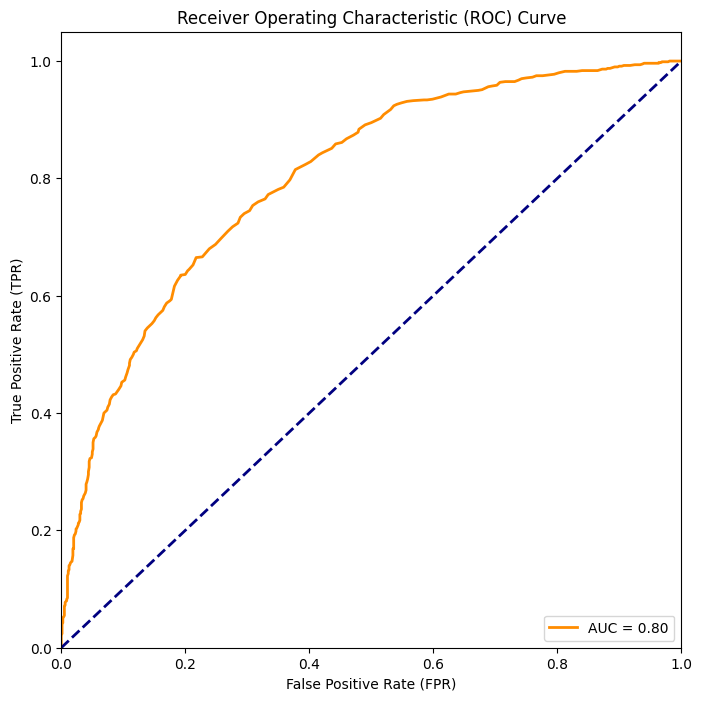

In [21]:
preds = no_w_metrics +  w_metrics
t_labels = [0] * len(no_w_metrics) + [1] * len(w_metrics)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

0.795


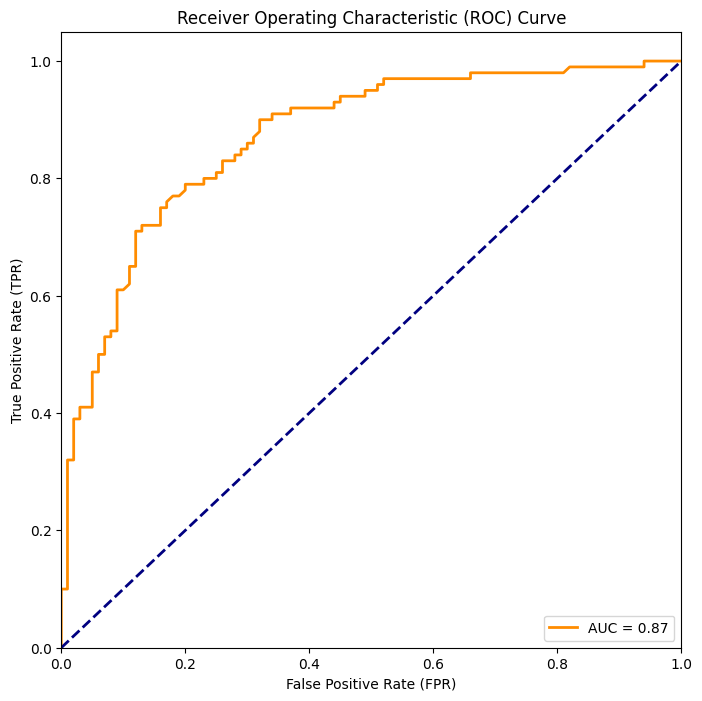

In [22]:
# 分割原始列表，每8个元素为一组
split_lists_no = [no_w_metrics[i:i+8] for i in range(0, len(no_w_metrics), 8)]

# 计算每组的平均值
average_values_no = [sum(sub_list) / len(sub_list) for sub_list in split_lists_no]

# 分割原始列表，每8个元素为一组
split_lists_w = [w_metrics[i:i+8] for i in range(0, len(w_metrics), 8)]

# 计算每组的平均值
average_values_w = [sum(sub_list) / len(sub_list) for sub_list in split_lists_w]

preds = average_values_no +  average_values_w
t_labels = [0] * len(average_values_no) + [1] * len(average_values_w)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)

import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [23]:
no_w_metrics=[]
w_metrics=[]
args.crop_scale=None
args.crop_ratio=None
args.r_degree=None
args.gaussian_blur_r=None
args.gaussian_std=None
args.brightness_factor=0.1
for idx_video in range(100):
    print(f'---------------------idx_video:{idx_video}----------------------------')
    for idx_frame in range(8):
        frame_path_no_w = f'{args.orig_img_no_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'
        frame_path_w = f'{args.orig_img_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'

        img_no_w = Image.open(frame_path_no_w)
        img_w = Image.open(frame_path_w)

        img_no_w, img_w = image_distortion(img_no_w, img_w, 42, args)

        img_no_w = transform_img(img_no_w).unsqueeze(0).to(text_embeddings.dtype).to(device)
        img_w = transform_img(img_w).unsqueeze(0).to(text_embeddings.dtype).to(device)

        image_latents_no_w = pipe.get_image_latents(img_no_w, sample=False)
        image_latents_w = pipe.get_image_latents(img_w, sample=False)

        reversed_latents_no_w = pipe.forward_diffusion(
        latents=image_latents_no_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )

        reversed_latents_w = pipe.forward_diffusion(
        latents=image_latents_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )

        no_w_metric, w_metric = eval_watermark(reversed_latents_no_w, reversed_latents_w, watermarking_mask, gt_patch, args)
        no_w_metrics.append(-no_w_metric)
        w_metrics.append(-w_metric)


---------------------idx_video:0----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.91it/s]


---------------------idx_video:1----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.78it/s]


---------------------idx_video:2----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.60it/s]


---------------------idx_video:3----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.85it/s]


---------------------idx_video:4----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.29it/s]


---------------------idx_video:5----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.96it/s]


---------------------idx_video:6----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.95it/s]


---------------------idx_video:7----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.26it/s]


---------------------idx_video:8----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.46it/s]


---------------------idx_video:9----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.25it/s]


---------------------idx_video:10----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.06it/s]


---------------------idx_video:11----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.95it/s]


---------------------idx_video:12----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.10it/s]


---------------------idx_video:13----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.12it/s]


---------------------idx_video:14----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.87it/s]


---------------------idx_video:15----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.68it/s]


---------------------idx_video:16----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.88it/s]


---------------------idx_video:17----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.71it/s]


---------------------idx_video:18----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.74it/s]


---------------------idx_video:19----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.76it/s]


---------------------idx_video:20----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.84it/s]


---------------------idx_video:21----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.81it/s]


---------------------idx_video:22----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.08it/s]


---------------------idx_video:23----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.05it/s]


---------------------idx_video:24----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.60it/s]


---------------------idx_video:25----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.88it/s]


---------------------idx_video:26----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.88it/s]


---------------------idx_video:27----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.92it/s]


---------------------idx_video:28----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.62it/s]


---------------------idx_video:29----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.17it/s]


---------------------idx_video:30----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.60it/s]


---------------------idx_video:31----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.89it/s]


---------------------idx_video:32----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.07it/s]


---------------------idx_video:33----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.20it/s]


---------------------idx_video:34----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.92it/s]


---------------------idx_video:35----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.86it/s]


---------------------idx_video:36----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.89it/s]


---------------------idx_video:37----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.86it/s]


---------------------idx_video:38----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.79it/s]


---------------------idx_video:39----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.37it/s]


---------------------idx_video:40----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.98it/s]


---------------------idx_video:41----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.59it/s]


---------------------idx_video:42----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.32it/s]


---------------------idx_video:43----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.22it/s]


---------------------idx_video:44----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.14it/s]


---------------------idx_video:45----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.79it/s]


---------------------idx_video:46----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.82it/s]


---------------------idx_video:47----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.96it/s]


---------------------idx_video:48----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.94it/s]


---------------------idx_video:49----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.93it/s]


---------------------idx_video:50----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.67it/s]


---------------------idx_video:51----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.93it/s]


---------------------idx_video:52----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.89it/s]


---------------------idx_video:53----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.74it/s]


---------------------idx_video:54----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.61it/s]


---------------------idx_video:55----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.96it/s]


---------------------idx_video:56----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.89it/s]


---------------------idx_video:57----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.10it/s]


---------------------idx_video:58----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.00it/s]


---------------------idx_video:59----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.06it/s]


---------------------idx_video:60----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.97it/s]


---------------------idx_video:61----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.62it/s]


---------------------idx_video:62----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.93it/s]


---------------------idx_video:63----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.70it/s]


---------------------idx_video:64----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.65it/s]


---------------------idx_video:65----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.08it/s]


---------------------idx_video:66----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.20it/s]


---------------------idx_video:67----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.20it/s]


---------------------idx_video:68----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.88it/s]


---------------------idx_video:69----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.93it/s]


---------------------idx_video:70----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.70it/s]


---------------------idx_video:71----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.53it/s]


---------------------idx_video:72----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.01it/s]


---------------------idx_video:73----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.78it/s]


---------------------idx_video:74----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.23it/s]


---------------------idx_video:75----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.62it/s]


---------------------idx_video:76----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.35it/s]


---------------------idx_video:77----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.46it/s]


---------------------idx_video:78----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.98it/s]


---------------------idx_video:79----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.26it/s]


---------------------idx_video:80----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.96it/s]


---------------------idx_video:81----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.79it/s]


---------------------idx_video:82----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.20it/s]


---------------------idx_video:83----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.47it/s]


---------------------idx_video:84----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.50it/s]


---------------------idx_video:85----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.84it/s]


---------------------idx_video:86----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.13it/s]


---------------------idx_video:87----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.23it/s]


---------------------idx_video:88----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.66it/s]


---------------------idx_video:89----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.85it/s]


---------------------idx_video:90----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.34it/s]


---------------------idx_video:91----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.03it/s]


---------------------idx_video:92----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.46it/s]


---------------------idx_video:93----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.98it/s]


---------------------idx_video:94----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.14it/s]


---------------------idx_video:95----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.91it/s]


---------------------idx_video:96----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.50it/s]


---------------------idx_video:97----------------------------


100%|██████████| 50/50 [00:00<00:00, 58.08it/s]


---------------------idx_video:98----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.93it/s]


---------------------idx_video:99----------------------------


100%|██████████| 50/50 [00:00<00:00, 57.86it/s]


0.9237500000000001


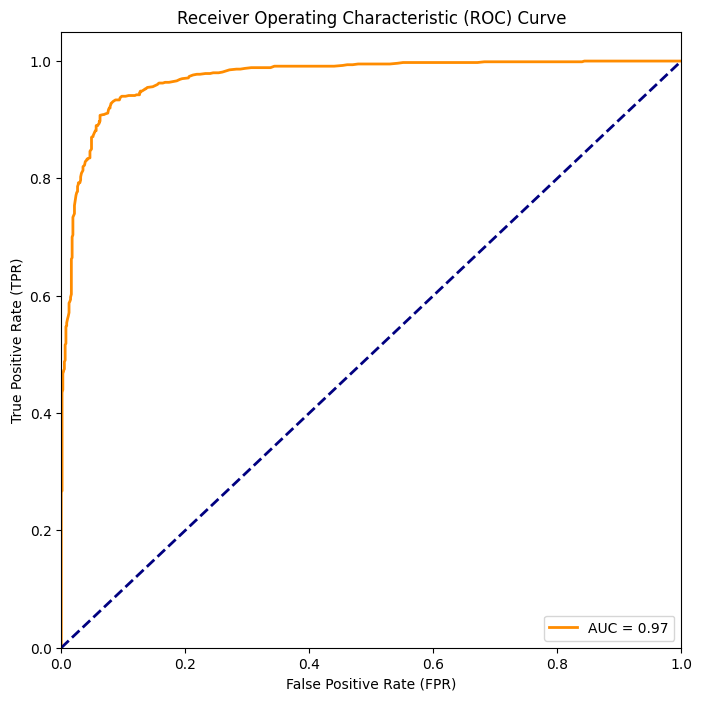

In [24]:
preds = no_w_metrics +  w_metrics
t_labels = [0] * len(no_w_metrics) + [1] * len(w_metrics)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

0.97


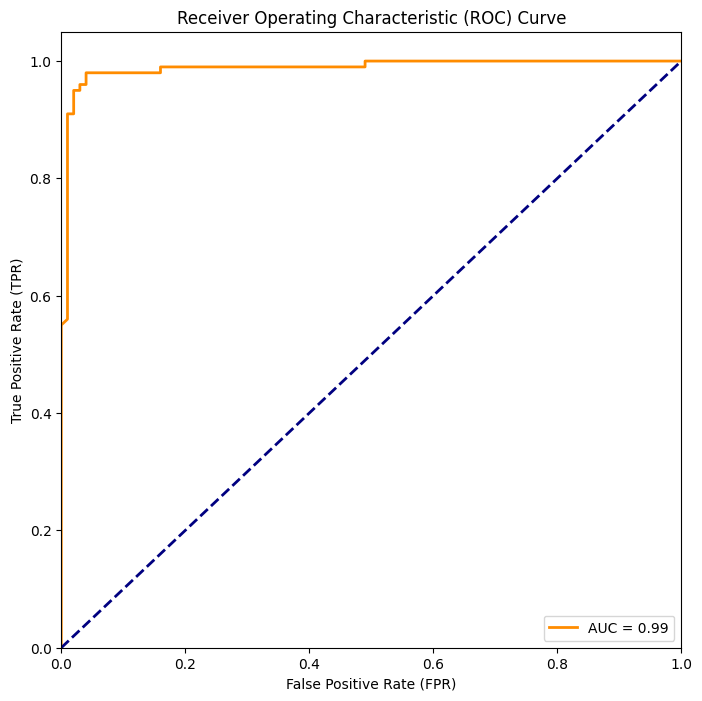

In [25]:
# 分割原始列表，每8个元素为一组
split_lists_no = [no_w_metrics[i:i+8] for i in range(0, len(no_w_metrics), 8)]

# 计算每组的平均值
average_values_no = [sum(sub_list) / len(sub_list) for sub_list in split_lists_no]

# 分割原始列表，每8个元素为一组
split_lists_w = [w_metrics[i:i+8] for i in range(0, len(w_metrics), 8)]

# 计算每组的平均值
average_values_w = [sum(sub_list) / len(sub_list) for sub_list in split_lists_w]

preds = average_values_no +  average_values_w
t_labels = [0] * len(average_values_no) + [1] * len(average_values_w)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)

import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()